<a href="https://colab.research.google.com/github/eddyarias/TIC_Modelos_Melanoma/blob/model-training/entrenamiento_clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '/content/TIC_Modelos_Melanoma/baseCode', 'models'))
from classification import load_model, print_layers
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [62]:
# Configuración de parámetros
backbone = 'densenet121'  # Cambia por el backbone que desees
weights = 'imagenet'  # 'none' o 'imagenet'
num_classes = 2
num_epochs = 50
learning_rate = 0.001
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo seleccionado: {device}")

Dispositivo seleccionado: cuda


In [63]:
metadata_path = '/content/drive/MyDrive/DatasetTIC/bcn20000_metadata_2025-07-22.csv'
images_dir = '/content/drive/MyDrive/DatasetTIC/ISIC-images'
df = pd.read_csv(metadata_path)
df = df[df['diagnosis_1'].isin(['Benign', 'Malignant'])]
df = df[df['isic_id'].notna()]
df = df.head(10000).copy()
df['filename'] = df['isic_id'].apply(lambda x: f"{x}.jpg")
df['filepath'] = df['filename'].apply(lambda x: os.path.join(images_dir, x))
df = df[df['filepath'].apply(os.path.exists)]
image_label_pairs = list(zip(df['filepath'], df['diagnosis_1']))

In [64]:
# Mapear los labels a índices numéricos para clasificación
label2idx = {label: idx for idx, label in enumerate(sorted(df['diagnosis_1'].unique()))}
label_col = 'diagnosis_1'
print('Diccionario de labels:', label2idx)

Diccionario de labels: {'Benign': 0, 'Malignant': 1}


In [ ]:
class MetadataImageDataset(Dataset):
    def __init__(self, dataframe, images_dir, label_col, transform=None):
        self.dataframe = dataframe
        self.images_dir = images_dir
        self.label_col = label_col
        self.transform = transform
        self.label2idx = label2idx

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['isic_id'] + '.jpg'
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.label2idx[row[self.label_col] if pd.notnull(row[self.label_col]) else 'Desconocido']

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = MetadataImageDataset(df, images_dir, label_col)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f"Número de clases detectadas: {len(label2idx)}")

In [66]:
model = load_model(backbone, weights, num_classes)
model = model.to(device)
print_layers(model)
print(f"Modelo {backbone} cargado con {num_classes} clases y pesos: {weights}")

Children Counter:  0  Layer Name:  features
Children Counter:  1  Layer Name:  classifier
Modelo densenet121 cargado con 2 clases y pesos: imagenet


In [67]:
# Usar el dataset personalizado con los labels mapeados
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dataset = MetadataImageDataset(df, images_dir, label_col, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f"Número de clases detectadas: {len(label2idx)}")
print(f"Número de imágenes usadas en entrenamiento: {len(train_dataset)}")

Número de clases detectadas: 2
Número de imágenes usadas en entrenamiento: 9553


In [68]:
# Definir función de entrenamiento
def train_model(model, train_loader, criterion, optimizer, device, num_epochs):
    history = {'loss': [], 'acc': []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        history['loss'].append(epoch_loss)
        history['acc'].append(epoch_acc)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}")
    return history

In [ ]:
# Entrenar el modelo
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
history = train_model(model, train_loader, criterion, optimizer, device, num_epochs)

# Guardar el modelo entrenado
model_path = f"modelo_{backbone}.pth"
torch.save(model.state_dict(), model_path)
print(f"Modelo guardado en {model_path}")

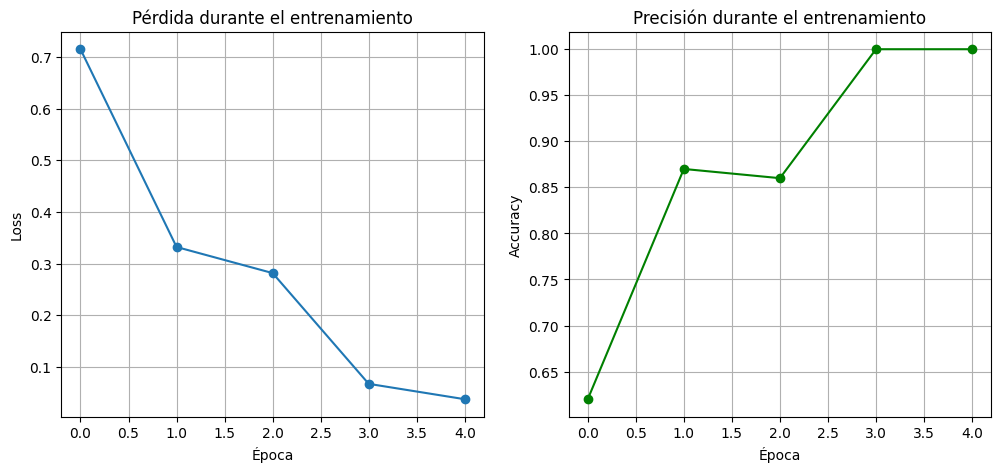

In [61]:
# Visualizar resultados del entrenamiento
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['loss'], marker='o')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history['acc'], marker='o', color='green')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()